# ** Описание **

In [16]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import pandas as pd
import numpy as np

from collections import namedtuple
from pymorphy2 import MorphAnalyzer

from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as PrecRecFbScore

%matplotlib inline
import matplotlib.pyplot as plt

morph = MorphAnalyzer()

In [17]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [48]:
# def to_utf8(text):
#     if isinstance(text, unicode): text = text.encode('utf8')
#     return text

# def convert2unicode(f):
#     def tmp(text):
#         if not isinstance(text, unicode): text = text.decode('utf8')
#         return f(text)
#     return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

# #P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [42]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

from html.parser import HTMLParser
import re

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        
        self._title = ""
        self._text = []
        self._anchors = []
        
        self._script_cnt = self._link_cnt = self._img_cnt = 0
        self._in_title = self._in_anchor = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            
            if self._in_title:
                self._title = text  
            elif self._in_anchor:
                self._anchors.append(text + ' ')
            else:
                self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'title':
            self._in_title = True
            return
        elif tag == 'a':
            self._in_anchor = True
            return
        elif tag == 'script':
            self._script_cnt += 1
        elif tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
            
    def handle_endtag(self, tag):
        if tag == 'title':
            self._in_title = False
        if tag == 'a':
            self._in_anchor = False

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')
        elif tag == 'img':
            self._img_cnt += 1
        elif tag == 'link':
            self._link_cnt += 1

    def text(self):
        return ''.join(self._text).strip()
    
    def title(self):
        return self._title
    
    def anchors_text(self):
        return ''.join(self._anchors).strip()
    
    def images(self):
        return self._img_cnt
    
    def links(self):
        return self._link_cnt
    
    def scripts(self):
        return self._script_cnt

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [20]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [21]:
html2text = html2text_parser

#### Методы для токенизации текста

In [49]:
@convert2lower
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None

def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [50]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [51]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

**Извлечем слова и фичи из html-текста**
=

In [52]:
def html_features(raw_html, Parser = TextHTMLParser, tokenizer=easy_tokenizer):
    
    parser = Parser()
    parser.feed(raw_html)
    
    title  = list(tokenizer(parser.title()))
    text   = list(tokenizer(parser.text()))
    anchors = list(tokenizer(parser.anchors_text()))
    
    images  = parser.images()
    links   = parser.links()
    scripts = parser.scripts()
    
    return { 'title'   : title,
             'text'    : text,
             'anchors' : anchors,
             'images'  : images,
             'links'   : links,
             'scripts' : scripts }

**Генерируем фичи**
=

In [53]:
def calc_features(url, html_data):
    compression_level = len(html_data) / len(zlib.compress(html_data.encode('utf-8')))
    features = html_features(html_data)
    
    title  = features['title']
    text   = features['text']
    anchor = features['anchors']
    
    images  = features['images']
    links   = features['links']
    scripts = features['scripts']
    
    title_words_num  = len(title)
    anchor_words_num = len(anchor)
    
    words_num = title_words_num + anchor_words_num + len(text)
    
    unique_title = set(title)
    unique_text = set(text)
    unique_anchor = set(anchor)
    
    def normalize(unique):
        to_delete = set()
        to_add = set()      
        for i in unique:   
            to_add1 = set()
            word = i.lower()       
            for parse in morph.parse(word):        
                norm = parse.normal_form
                to_add1.add(norm)          
                if word == norm:
                    break
            if word == norm:
                continue
            to_add |= to_add1
            to_delete.add(word)
        unique -= to_delete
        unique |= to_add
            
            
    normalize(unique_title)
    normalize(unique_text)
    normalize(unique_anchor)
        
    unique_words_num = len(unique_title) + len(unique_text) + len(unique_anchor)
    
    title_lengths   = np.array([], dtype = int)
    text_lengths    = np.array([], dtype = int)
    anchor_lengths  = np.array([], dtype = int)
    
    for word in title:
        np.append(title_lengths, len(word))
        
    for word in text:
        np.append(text_lengths, len(word))
        
    for word in anchor:
        np.append(anchor_lengths, len(word))
        
    if text_lengths.size > 0:
        max_len_text = max(text_lengths)
    else:
        max_len_text = 0
    
    if title_lengths.size > 0:
        max_len_title  = max(title_lengths)
    else:
        max_len_title = 0
    
    if anchor_lengths.size > 0:
        max_len_anchor = max(anchor_lengths)
    else:
        max_len_anchor = 0
    
    avg_word_len = ( title_lengths.sum() + text_lengths.sum() + anchor_lengths.sum() ) / words_num
    
    url_len = len(url)        
    url_dots = url.count('.') 
    url_slashes = url.count('/') 
    
    return [words_num,         
            unique_words_num,  
            avg_word_len,      
            title_words_num,   
            anchor_words_num,    
            compression_level,    
            url_len,           
            url_dots,         
            url_slashes,            
            scripts            
           ]

In [54]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[6, 6, 0.0, 2, 0, 0.8450704225352113, 12, 0, 2, 0]


In [60]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])
WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            
            try:
                html_data = base64.b64decode(pageInb64).decode("utf-8") 
            except UnicodeDecodeError:
                continue
                
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)
        
# def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
#     with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
#         headers = input_file.readline()
        
#         for i, line in enumerate(input_file):
#             trace_worker(i, worker_id)
#             if i % WORKER_NUM != worker_id: continue
#             parts = line.strip().split('\t')
#             url_id = int(parts[0])                                        
#             mark = bool(int(parts[1]))                    
#             url = parts[2]
#             pageInb64 = parts[3]
#             html_data = base64.b64decode(pageInb64)
#             try:
#                 html_data = html_data.decode('utf8')
#             except:
#                 html_data = html_data.decode('latin1')
#             features = calc_features_f(url, html_data)            
#             res_queue.put(DocItem(url_id, mark, url, features))
                
#         trace_worker(i, worker_id, 1)  
#     res_queue.put(None)
        
# def load_csv_multiprocess(input_file_name, calc_features_f):
#     processes = []
#     res_queue = Queue()    
#     for i in range(WORKER_NUM):
#         process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
#         processes.append(process)
#         process.start()
    
#     complete_workers = 0
#     while complete_workers != WORKER_NUM:
#         item = res_queue.get()
#         if item is None:
#             complete_workers += 1
#         else:
#             yield item
        
#     for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [63]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

17:15:02 INFO:Complete items 00000
17:16:06 INFO:Complete items 01000
17:17:02 INFO:Complete items 02000
17:18:01 INFO:Complete items 03000
17:19:02 INFO:Complete items 04000
17:20:04 INFO:Complete items 05000
17:20:56 INFO:Complete items 06000
17:22:01 INFO:Complete items 07000
17:22:03 INFO:Complete items 07043


CPU times: user 6min 59s, sys: 1.5 s, total: 7min
Wall time: 7min


**Графики**
=

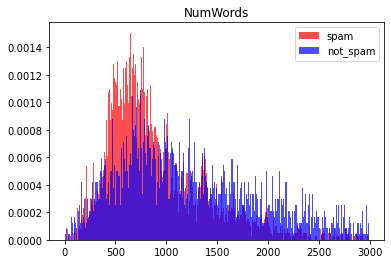

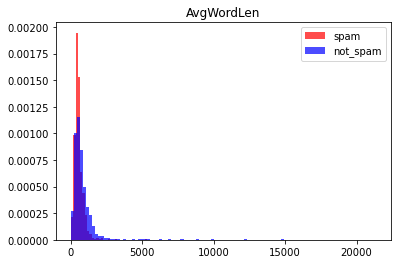

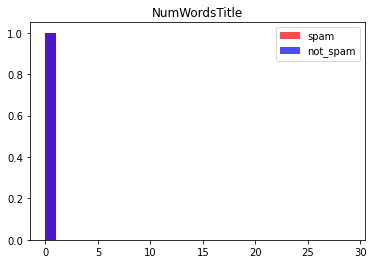

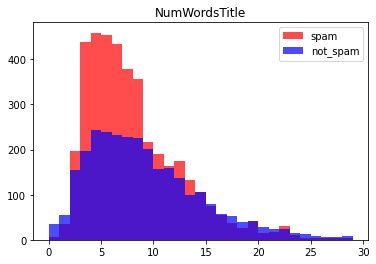

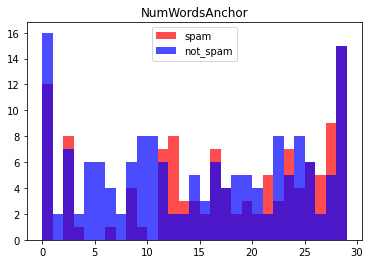

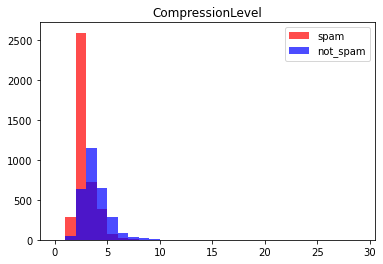

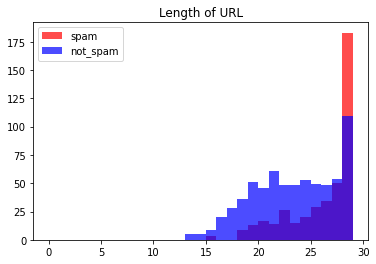

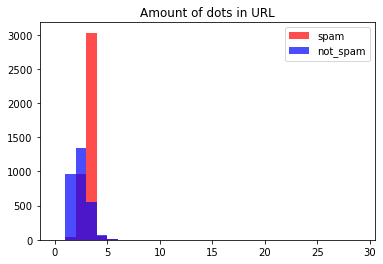

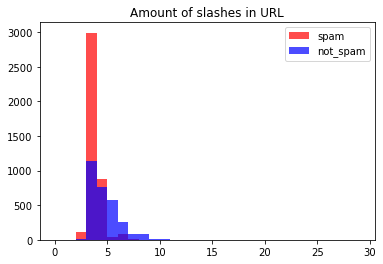

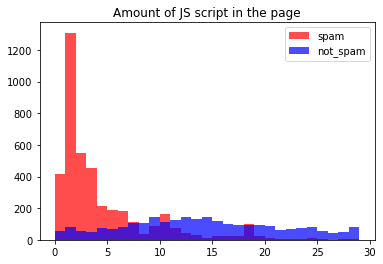

In [100]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('CompressionLevel')
plt.legend()
plt.show()

is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('Length of URL')
plt.legend()
plt.show()

is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('Amount of dots in URL')
plt.legend()
plt.show()

is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('Amount of slashes in URL')
plt.legend()
plt.show()

is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('Amount of JS script in the page')
plt.legend()
plt.show()

In [71]:
def calculate_metrics(docs, classifier):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    """
    
    predictions = classifier.predict_all(docs)
    
    true = [i[1] for i in predictions]
    predictions = [i[3] for i in predictions]
    
    precision, recall, F1, _ = PrecRecFbScore(true, predictions)
    
    not_class_prec,   class_prec   = precision[0], precision[1]
    not_class_recall, class_recall = recall[0],    recall[1]
    not_class_F1,     class_F1     = F1[0],        F1[1]
    
    return { 'class_prec' : class_prec,
             'class_recall' : class_recall,
             'class_F1' : class_F1,
             'not_class_prec' : not_class_prec,
             'not_class_recall' : not_class_recall,
             'not_class_F1' : not_class_F1 }

** Классификатор: **
Нужно реализовать

In [72]:
class Classifier:
        
    def __init__(self, n_estimators, learning_rate, max_depth):
        
        self.classifier = XGBClassifier(n_estimators  = n_estimators,
                                        learning_rate = learning_rate,
                                        max_depth     = max_depth)                    
    
    def predict_all(self, docs):
        ids = []
        urls = []
        marks = []
        predictions = []
        features = []
        
        for doc_num, doc in enumerate(docs):                            
            features.append(doc.features)
            ids.append(doc.doc_id)
            urls.append(doc.url)
            marks.append(doc.is_spam)
            trace(doc_num)
        
        predictions = self.classifier.predict(np.array(features))
        predictions = list(map(int, predictions))
        
        return list(zip(ids, marks, urls, predictions))
    
    def train(self, docs):        
        features = []
        marks = []
        
        for doc_num, doc in enumerate(docs):                            
            
            features.append(doc.features)
            marks.append(doc.is_spam)
            
            trace(doc_num)
            
        self.classifier.fit(np.array(features), np.array(marks))
            
        trace(doc_num, 1)

In [73]:
best_score = 0

for n_estimators in (500, 750, 1000):
    for learning_rate in (0.05, 0.1, 0.3):
        for max_depth in (3,6):
            
            classifier = Classifier(n_estimators = n_estimators,
                                    learning_rate = learning_rate,
                                    max_depth = max_depth)
            
            classifier.train(train_docs)
            print("{} Estimators, rate {}, depth {}".format(n_estimators, learning_rate, max_depth))
            metrics = calculate_metrics(train_docs, classifier)
            print(metrics)
            
            if (metrics['class_F1'] + metrics['not_class_F1']) / 2 > best_score:
                best_score = (metrics['class_F1'] + metrics['not_class_F1']) / 2
                best_model = classifier
            
            print('#############################')
            
print(best_model)

17:24:00 INFO:Complete items 00000
17:24:00 INFO:Complete items 01000
17:24:00 INFO:Complete items 02000
17:24:00 INFO:Complete items 03000
17:24:00 INFO:Complete items 04000
17:24:00 INFO:Complete items 05000
17:24:00 INFO:Complete items 06000
17:24:00 INFO:Complete items 07000


[17:24:00] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:00 INFO:Complete items 07042
17:24:00 INFO:Complete items 00000
17:24:00 INFO:Complete items 01000
17:24:00 INFO:Complete items 02000
17:24:00 INFO:Complete items 03000
17:24:00 INFO:Complete items 04000
17:24:00 INFO:Complete items 05000
17:24:00 INFO:Complete items 06000
17:24:00 INFO:Complete items 07000
17:24:00 INFO:Complete items 00000
17:24:00 INFO:Complete items 01000
17:24:00 INFO:Complete items 02000
17:24:00 INFO:Complete items 03000
17:24:00 INFO:Complete items 04000
17:24:00 INFO:Complete items 05000
17:24:00 INFO:Complete items 06000
17:24:00 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

500 Estimators, rate 0.05, depth 3
{'class_prec': 0.956573896353167, 'class_recall': 0.970309077634461, 'class_F1': 0.9633925335266401, 'not_class_prec': 0.9575652173913044, 'not_class_recall': 0.9383094751192911, 'not_class_F1': 0.9478395593045275}
#############################
[17:24:00] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:02 INFO:Complete items 07042
17:24:02 INFO:Complete items 00000
17:24:02 INFO:Complete items 01000
17:24:02 INFO:Complete items 02000
17:24:02 INFO:Complete items 03000
17:24:02 INFO:Complete items 04000
17:24:02 INFO:Complete items 05000
17:24:02 INFO:Complete items 06000
17:24:02 INFO:Complete items 07000
17:24:02 INFO:Complete items 00000
17:24:02 INFO:Complete items 01000
17:24:02 INFO:Complete items 02000
17:24:02 INFO:Complete items 03000
17:24:02 INFO:Complete items 04000
17:24:02 INFO:Complete items 05000
17:24:02 INFO:Complete items 06000
17:24:02 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

500 Estimators, rate 0.05, depth 6
{'class_prec': 0.9961032635168047, 'class_recall': 0.9953760038938915, 'class_F1': 0.995739500912964, 'not_class_prec': 0.9935308137555329, 'not_class_recall': 0.994546693933197, 'not_class_F1': 0.9940384942939874}
#############################
[17:24:02] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:03 INFO:Complete items 07042
17:24:03 INFO:Complete items 00000
17:24:03 INFO:Complete items 01000
17:24:03 INFO:Complete items 02000
17:24:03 INFO:Complete items 03000
17:24:03 INFO:Complete items 04000
17:24:03 INFO:Complete items 05000
17:24:03 INFO:Complete items 06000
17:24:03 INFO:Complete items 07000
17:24:03 INFO:Complete items 00000
17:24:03 INFO:Complete items 01000
17:24:03 INFO:Complete items 02000
17:24:03 INFO:Complete items 03000
17:24:03 INFO:Complete items 04000
17:24:03 INFO:Complete items 05000
17:24:03 INFO:Complete items 06000
17:24:03 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

500 Estimators, rate 0.1, depth 3
{'class_prec': 0.9743465634075508, 'class_recall': 0.979800438062789, 'class_F1': 0.9770658900618858, 'not_class_prec': 0.9714874613534867, 'not_class_recall': 0.9638718473074301, 'not_class_F1': 0.9676646706586827}
#############################
[17:24:03] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:05 INFO:Complete items 07042
17:24:05 INFO:Complete items 00000
17:24:05 INFO:Complete items 01000
17:24:05 INFO:Complete items 02000
17:24:05 INFO:Complete items 03000
17:24:05 INFO:Complete items 04000
17:24:05 INFO:Complete items 05000
17:24:05 INFO:Complete items 06000
17:24:05 INFO:Complete items 07000
17:24:05 INFO:Complete items 00000
17:24:05 INFO:Complete items 01000
17:24:05 INFO:Complete items 02000
17:24:05 INFO:Complete items 03000
17:24:05 INFO:Complete items 04000
17:24:05 INFO:Complete items 05000
17:24:05 INFO:Complete items 06000
17:24:05 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

500 Estimators, rate 0.1, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:05] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:06 INFO:Complete items 07042
17:24:06 INFO:Complete items 00000
17:24:06 INFO:Complete items 01000
17:24:06 INFO:Complete items 02000
17:24:06 INFO:Complete items 03000
17:24:06 INFO:Complete items 04000
17:24:06 INFO:Complete items 05000
17:24:06 INFO:Complete items 06000
17:24:06 INFO:Complete items 07000
17:24:06 INFO:Complete items 00000
17:24:06 INFO:Complete items 01000
17:24:06 INFO:Complete items 02000
17:24:06 INFO:Complete items 03000
17:24:06 INFO:Complete items 04000
17:24:06 INFO:Complete items 05000
17:24:06 INFO:Complete items 06000
17:24:06 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

500 Estimators, rate 0.3, depth 3
{'class_prec': 0.997808619430241, 'class_recall': 0.9973229496227792, 'class_F1': 0.9975657254138267, 'not_class_prec': 0.9962534059945504, 'not_class_recall': 0.9969325153374233, 'not_class_F1': 0.9965928449744462}
#############################
[17:24:06] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:07 INFO:Complete items 07042
17:24:07 INFO:Complete items 00000
17:24:07 INFO:Complete items 01000
17:24:07 INFO:Complete items 02000
17:24:07 INFO:Complete items 03000
17:24:07 INFO:Complete items 04000
17:24:07 INFO:Complete items 05000
17:24:07 INFO:Complete items 06000
17:24:07 INFO:Complete items 07000
17:24:07 INFO:Complete items 00000
17:24:07 INFO:Complete items 01000
17:24:07 INFO:Complete items 02000
17:24:07 INFO:Complete items 03000
17:24:07 INFO:Complete items 04000
17:24:07 INFO:Complete items 05000
17:24:07 INFO:Complete items 06000
17:24:07 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

500 Estimators, rate 0.3, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:07] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:08 INFO:Complete items 07042
17:24:08 INFO:Complete items 00000
17:24:08 INFO:Complete items 01000
17:24:08 INFO:Complete items 02000
17:24:08 INFO:Complete items 03000
17:24:08 INFO:Complete items 04000
17:24:08 INFO:Complete items 05000
17:24:08 INFO:Complete items 06000
17:24:08 INFO:Complete items 07000
17:24:08 INFO:Complete items 00000
17:24:08 INFO:Complete items 01000
17:24:08 INFO:Complete items 02000
17:24:08 INFO:Complete items 03000
17:24:08 INFO:Complete items 04000
17:24:08 INFO:Complete items 05000
17:24:08 INFO:Complete items 06000
17:24:08 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

750 Estimators, rate 0.05, depth 3
{'class_prec': 0.9650938854116514, 'class_recall': 0.9756631783889024, 'class_F1': 0.9703497519060874, 'not_class_prec': 0.965385946694358, 'not_class_recall': 0.9505794137695979, 'not_class_F1': 0.9579254679718358}
#############################
[17:24:08] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:10 INFO:Complete items 07042
17:24:10 INFO:Complete items 00000
17:24:10 INFO:Complete items 01000
17:24:10 INFO:Complete items 02000
17:24:10 INFO:Complete items 03000
17:24:10 INFO:Complete items 04000
17:24:10 INFO:Complete items 05000
17:24:10 INFO:Complete items 06000
17:24:10 INFO:Complete items 07000
17:24:10 INFO:Complete items 00000
17:24:10 INFO:Complete items 01000
17:24:10 INFO:Complete items 02000
17:24:10 INFO:Complete items 03000
17:24:10 INFO:Complete items 04000
17:24:10 INFO:Complete items 05000
17:24:10 INFO:Complete items 06000
17:24:10 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

750 Estimators, rate 0.05, depth 6
{'class_prec': 0.999513263567778, 'class_recall': 0.999513263567778, 'class_F1': 0.999513263567778, 'not_class_prec': 0.9993183367416496, 'not_class_recall': 0.9993183367416496, 'not_class_F1': 0.9993183367416496}
#############################
[17:24:10] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:12 INFO:Complete items 07042
17:24:12 INFO:Complete items 00000
17:24:12 INFO:Complete items 01000
17:24:12 INFO:Complete items 02000
17:24:12 INFO:Complete items 03000
17:24:12 INFO:Complete items 04000
17:24:12 INFO:Complete items 05000
17:24:12 INFO:Complete items 06000
17:24:12 INFO:Complete items 07000
17:24:12 INFO:Complete items 00000
17:24:12 INFO:Complete items 01000
17:24:12 INFO:Complete items 02000
17:24:12 INFO:Complete items 03000
17:24:12 INFO:Complete items 04000
17:24:12 INFO:Complete items 05000
17:24:12 INFO:Complete items 06000
17:24:12 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

750 Estimators, rate 0.1, depth 3
{'class_prec': 0.9842194707453266, 'class_recall': 0.9866147481138964, 'class_F1': 0.9854156538648517, 'not_class_prec': 0.9811901504787962, 'not_class_recall': 0.9778459441036128, 'not_class_F1': 0.9795151928986002}
#############################
[17:24:12] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:14 INFO:Complete items 07042
17:24:14 INFO:Complete items 00000
17:24:14 INFO:Complete items 01000
17:24:14 INFO:Complete items 02000
17:24:14 INFO:Complete items 03000
17:24:14 INFO:Complete items 04000
17:24:14 INFO:Complete items 05000
17:24:14 INFO:Complete items 06000
17:24:14 INFO:Complete items 07000
17:24:14 INFO:Complete items 00000
17:24:14 INFO:Complete items 01000
17:24:14 INFO:Complete items 02000
17:24:14 INFO:Complete items 03000
17:24:14 INFO:Complete items 04000
17:24:14 INFO:Complete items 05000
17:24:14 INFO:Complete items 06000
17:24:14 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

750 Estimators, rate 0.1, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:14] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:15 INFO:Complete items 07042
17:24:15 INFO:Complete items 00000
17:24:15 INFO:Complete items 01000
17:24:15 INFO:Complete items 02000
17:24:15 INFO:Complete items 03000
17:24:15 INFO:Complete items 04000
17:24:15 INFO:Complete items 05000
17:24:15 INFO:Complete items 06000
17:24:15 INFO:Complete items 07000
17:24:15 INFO:Complete items 00000
17:24:15 INFO:Complete items 01000
17:24:15 INFO:Complete items 02000
17:24:15 INFO:Complete items 03000
17:24:15 INFO:Complete items 04000
17:24:15 INFO:Complete items 05000
17:24:15 INFO:Complete items 06000
17:24:15 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

750 Estimators, rate 0.3, depth 3
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:15] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:17 INFO:Complete items 07042
17:24:17 INFO:Complete items 00000
17:24:17 INFO:Complete items 01000
17:24:17 INFO:Complete items 02000
17:24:17 INFO:Complete items 03000
17:24:17 INFO:Complete items 04000
17:24:17 INFO:Complete items 05000
17:24:17 INFO:Complete items 06000
17:24:17 INFO:Complete items 07000
17:24:17 INFO:Complete items 00000
17:24:17 INFO:Complete items 01000
17:24:17 INFO:Complete items 02000
17:24:17 INFO:Complete items 03000
17:24:17 INFO:Complete items 04000
17:24:17 INFO:Complete items 05000
17:24:17 INFO:Complete items 06000
17:24:17 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

750 Estimators, rate 0.3, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:17] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:19 INFO:Complete items 07042
17:24:19 INFO:Complete items 00000
17:24:19 INFO:Complete items 01000
17:24:19 INFO:Complete items 02000
17:24:19 INFO:Complete items 03000
17:24:19 INFO:Complete items 04000
17:24:19 INFO:Complete items 05000
17:24:19 INFO:Complete items 06000
17:24:19 INFO:Complete items 07000
17:24:19 INFO:Complete items 00000
17:24:19 INFO:Complete items 01000
17:24:19 INFO:Complete items 02000
17:24:19 INFO:Complete items 03000
17:24:19 INFO:Complete items 04000
17:24:19 INFO:Complete items 05000
17:24:19 INFO:Complete items 06000
17:24:19 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

1000 Estimators, rate 0.05, depth 3
{'class_prec': 0.9750484496124031, 'class_recall': 0.979557069846678, 'class_F1': 0.9772975597911862, 'not_class_prec': 0.9711835334476844, 'not_class_recall': 0.9648943421949557, 'not_class_F1': 0.9680287228586083}
#############################
[17:24:19] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:22 INFO:Complete items 07042
17:24:22 INFO:Complete items 00000
17:24:22 INFO:Complete items 01000
17:24:22 INFO:Complete items 02000
17:24:22 INFO:Complete items 03000
17:24:22 INFO:Complete items 04000
17:24:22 INFO:Complete items 05000
17:24:22 INFO:Complete items 06000
17:24:22 INFO:Complete items 07000
17:24:22 INFO:Complete items 00000
17:24:22 INFO:Complete items 01000
17:24:22 INFO:Complete items 02000
17:24:22 INFO:Complete items 03000
17:24:22 INFO:Complete items 04000
17:24:22 INFO:Complete items 05000
17:24:22 INFO:Complete items 06000
17:24:22 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

1000 Estimators, rate 0.05, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:22] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:24 INFO:Complete items 07042
17:24:24 INFO:Complete items 00000
17:24:24 INFO:Complete items 01000
17:24:24 INFO:Complete items 02000
17:24:24 INFO:Complete items 03000
17:24:24 INFO:Complete items 04000
17:24:24 INFO:Complete items 05000
17:24:24 INFO:Complete items 06000
17:24:24 INFO:Complete items 07000
17:24:24 INFO:Complete items 00000
17:24:24 INFO:Complete items 01000
17:24:24 INFO:Complete items 02000
17:24:24 INFO:Complete items 03000
17:24:24 INFO:Complete items 04000
17:24:24 INFO:Complete items 05000
17:24:24 INFO:Complete items 06000
17:24:24 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

1000 Estimators, rate 0.1, depth 3
{'class_prec': 0.9890829694323144, 'class_recall': 0.9922122170844487, 'class_F1': 0.9906451220993804, 'not_class_prec': 0.9890448476549127, 'not_class_recall': 0.9846625766871165, 'not_class_F1': 0.9868488471391973}
#############################
[17:24:24] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:27 INFO:Complete items 07042
17:24:27 INFO:Complete items 00000
17:24:27 INFO:Complete items 01000
17:24:27 INFO:Complete items 02000
17:24:27 INFO:Complete items 03000
17:24:27 INFO:Complete items 04000
17:24:27 INFO:Complete items 05000
17:24:27 INFO:Complete items 06000
17:24:27 INFO:Complete items 07000
17:24:27 INFO:Complete items 00000
17:24:27 INFO:Complete items 01000
17:24:27 INFO:Complete items 02000
17:24:27 INFO:Complete items 03000
17:24:27 INFO:Complete items 04000
17:24:27 INFO:Complete items 05000
17:24:27 INFO:Complete items 06000
17:24:27 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

1000 Estimators, rate 0.1, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:27] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:29 INFO:Complete items 07042
17:24:29 INFO:Complete items 00000
17:24:29 INFO:Complete items 01000
17:24:29 INFO:Complete items 02000
17:24:29 INFO:Complete items 03000
17:24:29 INFO:Complete items 04000
17:24:29 INFO:Complete items 05000
17:24:29 INFO:Complete items 06000
17:24:29 INFO:Complete items 07000
17:24:29 INFO:Complete items 00000
17:24:29 INFO:Complete items 01000
17:24:29 INFO:Complete items 02000
17:24:29 INFO:Complete items 03000
17:24:29 INFO:Complete items 04000
17:24:29 INFO:Complete items 05000
17:24:29 INFO:Complete items 06000
17:24:29 INFO:Complete items 07000
/Users/ninakamkia/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1]

1000 Estimators, rate 0.3, depth 3
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################
[17:24:29] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


17:24:32 INFO:Complete items 07042
17:24:32 INFO:Complete items 00000
17:24:32 INFO:Complete items 01000
17:24:32 INFO:Complete items 02000
17:24:32 INFO:Complete items 03000
17:24:32 INFO:Complete items 04000
17:24:32 INFO:Complete items 05000
17:24:32 INFO:Complete items 06000
17:24:32 INFO:Complete items 07000


1000 Estimators, rate 0.3, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


In [76]:
test_docs = list(load_csv('kaggle_test_data_tab.csv', calc_features))

17:25:40 INFO:Complete items 00000
17:26:53 INFO:Complete items 01000
17:27:59 INFO:Complete items 02000
17:29:10 INFO:Complete items 03000
17:30:15 INFO:Complete items 04000
17:31:17 INFO:Complete items 05000
17:32:23 INFO:Complete items 06000
17:33:28 INFO:Complete items 07000
17:34:31 INFO:Complete items 08000
17:35:33 INFO:Complete items 09000
17:36:45 INFO:Complete items 10000
17:37:45 INFO:Complete items 11000
17:38:47 INFO:Complete items 12000
17:39:46 INFO:Complete items 13000
17:40:52 INFO:Complete items 14000
17:41:59 INFO:Complete items 15000
17:43:05 INFO:Complete items 16000
17:43:08 INFO:Complete items 16038


In [77]:
preds = best_model.predict_all(test_docs)

ids = [i[0] for i in preds]
predictions = [i[3] for i in preds]

res = np.array(list(zip(ids, predictions)))
df = pd.DataFrame(res, columns = ['Id', 'Prediction'])
df.to_csv('submission.csv', index = False)

17:43:53 INFO:Complete items 00000
17:43:53 INFO:Complete items 01000
17:43:53 INFO:Complete items 02000
17:43:53 INFO:Complete items 03000
17:43:53 INFO:Complete items 04000
17:43:53 INFO:Complete items 05000
17:43:53 INFO:Complete items 06000
17:43:53 INFO:Complete items 07000
17:43:53 INFO:Complete items 08000
17:43:53 INFO:Complete items 09000
17:43:53 INFO:Complete items 10000
17:43:53 INFO:Complete items 11000
17:43:53 INFO:Complete items 12000
17:43:53 INFO:Complete items 13000
17:43:53 INFO:Complete items 14000
17:43:53 INFO:Complete items 15000
17:43:53 INFO:Complete items 16000


In [78]:
pd.read_csv('submission.csv')

,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,0
3,-9215626373068452590,0
4,-9215403080479774736,1
...,...,...
16034,9218204062988789622,0
16035,9220928100490675079,1
16036,9221176609623644378,0
16037,9222842529328016414,0


** Рисуем графики **

In [79]:
plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

17:43:58 INFO:Complete items 00000
17:43:58 INFO:Complete items 01000
17:43:58 INFO:Complete items 02000
17:43:58 INFO:Complete items 03000
17:43:58 INFO:Complete items 04000
17:43:58 INFO:Complete items 05000
17:43:58 INFO:Complete items 06000
17:43:58 INFO:Complete items 07000


AttributeError: 'int' object has no attribute 'predict_all'

In [ ]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'

test_docs = load_csv_multiprocess(TEST_DATA_FILE, calc_features)

threshold = 800

with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ninakamkia/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ninakamkia/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ninakamkia/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ninakamkia/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ninakamkia/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'load_csv_worker' on <module '__main__' (built-in)>
    self = reduction.pickle.load(from_parent)
AttributeError